## Задание 07 

In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import matplotlib.pyplot as plt

import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

import ndlib.models.epidemics.SIModel as si
import ndlib.models.epidemics.SISModel as sis
import ndlib.models.epidemics.SIRModel as sir
import ndlib.models.ModelConfig as mc

### 1. Влияние топологии на характерное время распространение эпидемии в SI модели.

* Сгенерируйте случайные графы из разных моделей: Эрдеша-Реньи, Барабаши-Альберта, Ваттса-Строгатца. 

Число вершин всех графов $N=10^4$, а средняя степень у всех примерно одинакова и, например, $\left< k\right>\approx10$. 

* Смоделируйте SI модель, изобразите на одном графике среднюю долю инфицированных от времени для разных графов.  

Параметры модели SI - $\beta$ и число шагов по времени - подберите самостоятельно. Усреднение можно проводить по 100 запускам SI (Не по графам!!!).

На этом же графике изобразите кривую, отвечающую приближению среднего поля. 

* Видите ли вы отличия в распространении эпидемии? Объясните результаты. 

In [9]:
n = 10000
Ge = nx.erdos_renyi_graph(n, 0.001, seed=1234)
Gb = nx.barabasi_albert_graph(n, 10, seed=1234)
Gw = nx.watts_strogatz_graph(n, 10, 0.5, seed=1234)
graphs = [Ge, Gb, Gw]

In [12]:
def SI(G, beta_=0.01, lambda_=None): 
    desc = np.zeros((150, 100))
    model = si(G)
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', beta_)
    if lambda_:
        cfg.add_model_parameter('lambda', lambda_)
    model.set_initial_status(cfg)

    for j in tqdm(range(100)):
        model.reset()
        for i in range(150):
            stat = model.get_status_map()
            it = model.iteration()
            desc[i][j] = it['node_count'][1]
            
    return desc

In [14]:
des = [SI(g) for g in graphs]

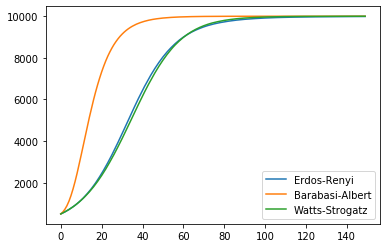

In [15]:
sns.lineplot(range(150), np.mean(des[0], 1), label="Erdos-Renyi")
sns.lineplot(range(150), np.mean(des[1], 1), label="Barabasi-Albert")
sns.lineplot(range(150), np.mean(des[2], 1), label="Watts-Strogatz")
plt.legend()
plt.show()

In [ ]:
Различие есть. Модель барбаши альберта 

### 2. Порог зажигания в модели SIS.
Рассмотрим модель SIS с параметром $\mu=1$ на двух графах из задания 1: Эрдеша-Реньи и Барабаши-Альберта. 
Так как $\left< k\right>\approx10$ и $\mu=1$, то пороговое значение $\beta$, выше которого  эпидемия не затухает из приближения среднего поля:
$$
\beta=\frac{1}{\left< k\right>}\approx 0.1,
$$

Постройте зависимость средней доли зараженных в сетях от параметра $\beta$, $\beta \in\left[0,0.2 \right]$. Усреднение проводите по 100 запускам SIS. Число шагов по времени (итераций) определите самостоятельно. 

In [28]:
def SIS(G, betas):
    ratios = []
    for b in tqdm(betas):
        model = sis(Ge)
        cfg = mc.Configuration()
        cfg.add_model_parameter('lambda', 1)
        cfg.add_model_parameter('beta', b)
        model.set_initial_status(cfg)
        buf = []
        for j in range(1): 
            model.reset()
            buf.append(model.iteration_bunch(150)[-1]['node_count'][1])
        ratios.append(np.mean(buf))
    return ratios

In [29]:
betas = np.arange(0, 0.2, 0.02)
infratios = [SIS(g, betas) for g in graphs[:-1]]

/home/kim/juche/pet-projects/networksch/networks/lib/python3.6/site-packages/ndlib/models/DiffusionModel.py:116: UserWarning: Initial infection missing: a random sample of 5% of graph nodes will be set as infected
  warnings.warn('Initial infection missing: a random sample of 5% of graph nodes will be set as infected')


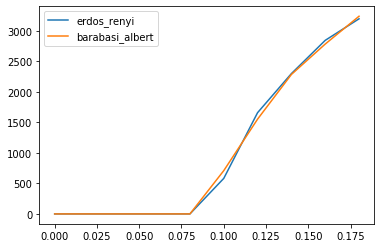

In [31]:
sns.lineplot(betas, infratios[0], label="erdos_renyi")
sns.lineplot(betas, infratios[1], label="barabasi_albert")
plt.legend()
plt.show()

### 3. Влияние топологии в модели SIR.
Рассмотрим модель SIR на следующих сетях: 

In [33]:
G1 = nx.read_graphml('../data/graph1.graphml')
G2 = nx.read_graphml('../data/graph2.graphml')

* Постройте зависимости средней доли зараженных вершин в модели SIR для первого и второго графа.

Параметры для моделирования:

In [34]:
def SIR(G, n_iter=200, n_run=100, beta=0.005, gamma=0.3, percentage_infected=0.002):
    model = sir(G)
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', beta)
    cfg.add_model_parameter('gamma', gamma)
    cfg.add_model_parameter('percentage_infected', percentage_infected)
    model.set_initial_status(cfg)

    des = np.zeros((n_iter, n_run))
    for j in tqdm(range(n_run)):
        model.reset()
        for i in range(n_iter):
            stat = model.get_status_map()
            it = model.iteration()
            des[i][j] = it['node_count'][1]
    return des

In [ ]:
sir_infected_beta_0005 = [SIR(g) for g in [G1, G2]]

In [ ]:
sns.lineplot(range(200), np.mean(sir_infected_beta_0005[0], 1), label="1st graph")
sns.lineplot(range(200), np.mean(sir_infected_beta_0005[1], 1), label="2nd graph")
plt.legend()
pltlt.show

* Отличаются ли построенные зависимости? 
Попробуйте понять, что влияет на распространение в сети, для этого исследуйте топологию G1, G2. 

In [ ]:
sir_infected_beta_001 = [SIR(g, beta=0.01, gamma=0.05) for g in [G1, G2]]

In [ ]:
sns.lineplot(range(n_iter), np.mean(sir_infected_beta_001[0], 1), label="1st graph")
sns.lineplot(range(n_iter), np.mean(sir_infected_beta_001[1], 1), label="2nd graph")
plt.legend()
plt.show()

In [ ]:
sir_infected_beta_005 = [SIR(g, beta=0.05, gamma=0.1, percentage_infected=0.01) for g in [G1, G2]]

In [ ]:
sns.lineplot(range(n_iter), np.mean(sir_infected_beta_005[0], 1), label="1st graph")
sns.lineplot(range(n_iter), np.mean(sir_infected_beta_005[1], 1), label="2nd graph")
plt.legend()
plt.show()

* Поменяйте параметры модели, всегда ли распространение "чувствительно" к топологии сети?

### 4. Моделирование распространения Covid-19. 
Будем работать с [данными](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset) по распространению коронавируса в мире. 

* Визуализируйте данные для выбранных стран, например в виде зависимостей логарифма числа зараженных от времени. 

* Оцените коэффициет роста числа зараженных - коэффициент в экспоненциальной зависимости, как его можно интерпретировать? 

* (дополнительно) Попробуйте смоделировать распространение в рамках SIR модели (в приближении среднего поля) для провинции Хубей (Китай). 

* (дополнительно) Какие прогнозы можно сделать по ситуации в России? 

In [ ]:
data = pd.read_csv("covid.csv")
data.head()

In [ ]:
dsum = data.iloc[:,11:]
dsum.head()

In [ ]:
cor = np.array(dsum.sum(axis=0))

In [ ]:
x, y = range(len(cor)), cor
plt.plot(x, y)
plt.yscale("log")
plt.title("US")
plt.show()

In [ ]:
np.polyfit(np.log(x), y, 1)